# Programmierübung 2: Physikalische Simulation eines Roboterarms im Freilauf
Version 1.0.0

### Vorbereitung
Bitte installiere zunächst die benötigten Bibliotheken für diese Programmierübung. 
Dies kannst du tun, indem du mit deinem Terminal zunächst in das (entpackte) Verzeichnis dieser Programmierübung navigierst.
Dort solltest du neben diesem Notebook auch ein Verzeichnis "cer_pex2_lib" sehen.
Installiere dieses mittels
```bash
pip install ./cer_pex2_lib
```
Bei der Installation dieses Pakets werden alle in dieser Übung benötigten Pakete automatisch mitinstalliert.

### Module importieren
Hier importieren wir die benötigten Module für diese Programmierübung.
Bitte importiere keine weiteren Module, die hier aufgeführten sind ausreichend um die Aufgabe zu bearbeiten.

In [1]:
%matplotlib notebook
import time
from typing import Tuple, List, Sequence, Callable
import numpy as np

import matplotlib

matplotlib.use("nbAgg")
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.axis import Axis

try:
    from cer_pex2 import RobotArm, test_almost_zero, test_geq, test_true, check_shape, ground_truth_trajectories
except ImportError:
    print(
        "I did not find the cer_pex2 library. Please make sure you installed it via \"pip install /path/to/cer_pex2_lib\".")
    raise

### Visualisierung aufsetzen
Mit dieser Funktion erzeugen wir die Matplotlib Axen, auf denen wir die Roboter rendern. Du kannst gerne an den Einstellungen hier herumspielen, um die Visualisierung besser an deine Bedürfnisse anzupassen.

In [2]:
def setup_axes(count: int) -> Tuple[plt.Figure, Sequence[Axis]]:
    # Feel free to adapt these settings to better match your liking
    columns = min(3, count)
    rows = int(np.ceil(count / 3))
    plt.rcParams["figure.figsize"] = [9.8, 4 * rows]
    plt.rcParams["figure.autolayout"] = True
    fig, axes = plt.subplots(rows, columns, squeeze=False)
    fig.tight_layout()

    # Initialize all three arms
    for i, ax in enumerate(axes.reshape(-1)):
        # Setup axes for visualization
        ax.set_title("Arm {}".format(i))
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect("equal")
        ax.xaxis.set_major_locator(MultipleLocator(0.4))
        ax.yaxis.set_major_locator(MultipleLocator(0.4))
        ax.xaxis.set_minor_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.2))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.yaxis.set_label_coords(-0.15, 0.5)
        ax.grid()
        ax.grid(which="minor")
    return fig, axes.reshape((-1,))[:count]

### Testfunktion für Integrationsverfahren
Hier gibt es nichts zu tun. Mit dieser Funktion testen wir die von euch implementierten Integrationsverfahren.

In [3]:
def test_integrator(integrator: Callable[[Callable[[np.ndarray], np.ndarray], np.ndarray, float, int], np.ndarray]):
    fig, axes = setup_axes(len(ground_truth_trajectories))

    for i, (ax, gt_trajectory) in enumerate(zip(axes, ground_truth_trajectories)):
        # Get params from the trajectory
        l = gt_trajectory.l
        m = gt_trajectory.m
        g = gt_trajectory.g
        dt = gt_trajectory.dt
        max_mean_err = gt_trajectory.allowed_mean_deviation[integrator.__name__]

        title = "Arm {} (m1={:0.1f}, m2={:0.1f})\nmax mean error: {:0.2e}\n".format(i, m[0], m[1], max_mean_err)

        ax.set_title(title)

        # Set up robot
        arm = RobotArm(fig, ax, l)
        arm.render()

        # Starting point is the first state in the ground truth trajectory
        x0 = gt_trajectory.states[0]

        # Extract parameters from ground truth trajectory
        dt = gt_trajectory.dt
        n = gt_trajectory.states.shape[0]

        # Use your integrator to compute a trajectory
        trajectory = integrator(lambda x: forward_dynamics(x, l, m, g), x0, dt, n)

        check_shape(trajectory, gt_trajectory.states.shape, "trajectory")

        # Render the generated trajectory and the ground truth
        arm.start_drawing()

        # Do not render every step to speed up the visualization 
        # (feel free to cahnge this if you want to see more steps)
        render_interval = 10
        last_render_time = 0.0
        for j, (x, x_gt) in enumerate(zip(trajectory, gt_trajectory.states)):
            arm.set_joint_pos(x[:2])
            arm.set_shadow_joint_pos(x_gt[:2])

            if j % render_interval == 0:
                now = time.time()
                time.sleep(max(0.0, last_render_time + render_interval * dt - now))

                # Update visualization 
                mean_error = np.mean(
                    np.linalg.norm(trajectory[:j + 1, :2] - gt_trajectory.states[:j + 1, :2], axis=-1))
                passed = mean_error <= max_mean_err
                new_title = title + "mean error: {:.2e}".format(mean_error)
                ax.set_title(new_title, color="green" if passed else "red")
                arm.render()

                last_render_time = now

        mean_error = np.mean(np.linalg.norm(trajectory[:, :2] - gt_trajectory.states[:, :2], axis=-1))
        passed = mean_error <= max_mean_err
        new_title = title + "mean error: {:.2e} ({})".format(mean_error, "passed" if passed else "failed")
        ax.set_title(new_title, color="green" if passed else "red")

        arm.render()

## 1. Implementierung der Bewegungsgleichung des Roboters

In [6]:
def forward_dynamics(x: np.ndarray, l: np.ndarray, m: np.ndarray, g: float) -> np.ndarray:
    """
    Evaluates the differential equation of the double pendulum, given its state x.
    :param x: 4D numpy array containing the state of the robot (q1, q2, dq1, dq2).
    :param l: 2D numpy array containing the link length in meters.
    :param m: 2D numpy array containing the joint masses in kilograms.
    :param g: Gravitational acceleration.
    :return: Output of the system dynamics x_d = f(x).
    """
    # Implement this...
    dq1 =  np.divide(
    0.5 * np.square(x[2]) * l[0] *  m[1] * np.sin(2 * x[1]) + m[1]*np.square(x[2] + x[3])*l[1]*np.sin(x[1])
         - g*((m[0]+m[1])*np.cos(x[0]) - m[1]*np.cos(x[0]+x[1])*np.cos(x[1]))
        , l[0] * (m[0] + m[1] * np.square(np.sin(x[1]))))
    dq2 = -dq1*(1+np.divide(l[0],l[1])*np.cos(x[1])) - np.square(x[2])*np.divide(l[0],l[1])*np.sin(x[1])-np.divide(g,l[1])*np.cos(x[0]+x[1])
    result = np.array([ x[2], x[3], dq1, dq2 ], dtype = np.float64)
    return result


### Öffentliche Tests

In [7]:
test_cases = [
    (([0.785398, 0., 0., 0.],            [1.0, 1.0]), [0., 0., -9.248957, 9.248957]),
    (([1.047198, 1.047198, 0., 0.],      [1.0, 1.0]), [0., 0., -9.342857, 21.355102]),
    (([0.523599, 0.523599, -1.0, 0.5],   [0.5, 0.7]), [-1.0, 0.5, -13.694363, 18.858291]),
    (([2.094395, 1.570796, 0.2, 3.0],    [0.1, 0.2]), [0.2, 3.0, 12.911556, -0.817685]),
    (([0.523599, -0.523599, -4.0, -7.0], [1.2, 0.3]), [-4.0, -7.0, -25.577722, 43.868033]),
    (([1.047198, -1.047198, -0.1, 0.1],  [0.1, 0.1]), [-0.1, 0.1, -3.739617, -8.262023])]

l = np.array([0.75, 0.7])
g = 9.81

for i, ((x, m), tar) in enumerate(test_cases):
    # Compute DGL step using your function
    x_d = forward_dynamics(np.array(x), np.array(l), m, g)

    # Check shapes
    check_shape(x_d, (4,), "x_d")

    test_almost_zero(i, np.linalg.norm(x_d - tar))

Test 0: passed.
Test 1: passed.
Test 2: passed.
Test 3: passed.
Test 4: passed.
Test 5: passed.


## 2. Implementierung des expliziten Euler-Verfahrens
**Hinweis**: am Ende des Dokuments findest du eine Spielwiese, in der du deine Integratoren mit verschiedenen Werten testen kannst.

In [9]:
def expl_euler(f: Callable[[np.ndarray], np.ndarray], x0: np.ndarray, dt: float, n: int) -> np.ndarray:
    """
    Computes the simulation steps using the explicit Euler method.
    :param f:   Function to integrate. Maps from an M-D numpy array to an M-D numpy array of time derivatives.
    :param x0:  M-D numpy array defining the starting point for the integration.
    :param dt:  Time step for the integration.
    :param n:   Number of steps to take.
    :return:    A n x M numpy array containing all intermediate states of the integration. The first element of this array must be x0.
    """
    # Implement this...
    z = np.zeros((n, x0.shape[0]))
    z[0] = x0
    for i in range (n-1):
        z[i+1] = z[i] + dt * f(z[i])
    return z


### Öffentliche Tests

<IPython.core.display.Javascript object>


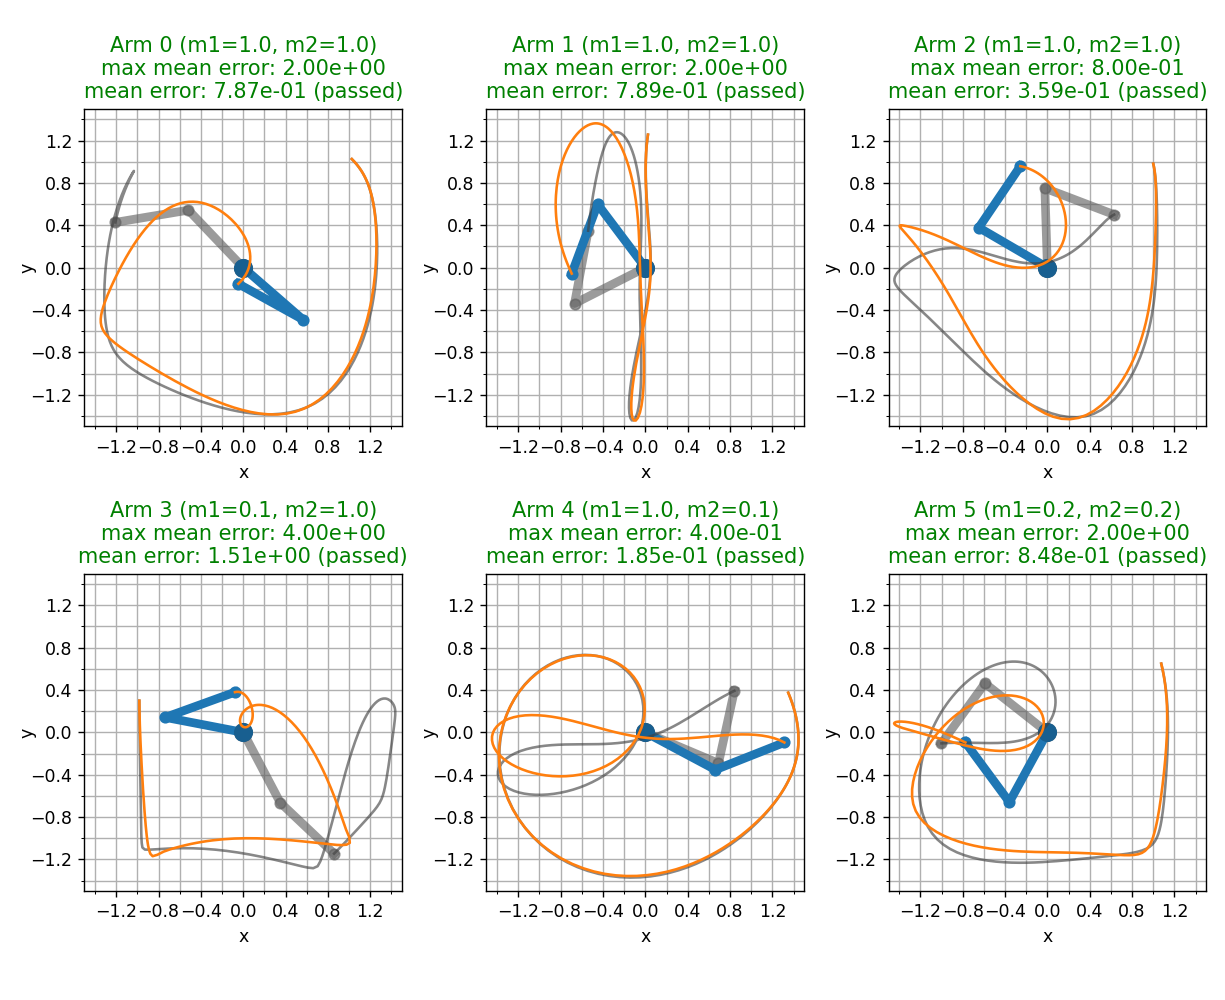

In [10]:
test_integrator(expl_euler)

Wie wir sehen hängt die Genauigkeit der Integration stark von den Startwerten und den Parametern des Roboters ab. Insbesondere wenn die Massen sehr unterschiedlich sind (siehe Arm 3), kann die ODE an manchen Stellen sehr steif sein und die Integration erschweren. Das muss jedoch nicht der Fall sein, wenn der Startwert günstig gewählt ist, wie wir an Arm 4 sehen. Wir werden im folgenden sehen, dass andere Verfahren besser mit problematischen ODEs umgehen können.

## 3. Implementierung des Vorwärtsdifferenzenquotienten

In [13]:
def forward_dq(f: Callable[[np.ndarray], np.ndarray], x: np.ndarray, d: float) -> np.ndarray:
    """
    Approximates the Jacobian J_fx of the given function f at position x via the forward difference quotient.
    :param f: Function to estimate Jacobian for. Maps from an M-D numpy array to an N-D numpy array.
    :param x: Position to approximate Jacobian at.
    :param d: Steps size for the forward difference quotient.
    :return: A NxM numpy array containing the approximated Jacobian of f at position x.
    """
    # Implement this...
    m = x.shape[0]
    n = f(x).shape[0]
    jf = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            e = np.zeros(m)
            e[j] = d
            jf[i][j] = np.multiply(np.divide(1.0, d), np.subtract((f(np.add(x, e)))[i], (f(x))[i])) 
    return jf



### Öffentliche Tests

In [14]:
test_cases = [
    (([0.785398, 0., 0., 0.], [1.0, 1.0]),            [[0., 0., 1.0, 0.], 
                                                       [0., 0., 0., 1.0], 
                                                       [9.248961, -9.248957, 0., 0.], 
                                                       [-9.248961, 29.06815, 0., 0.]]),
    (([1.047198, 1.047198, 0., 0.], [1.0, 1.0]),      [[0., 0., 1.0, 0.], 
                                                       [0., 0., 0., 1.0], 
                                                       [9.709387, 4.623518, 0.000001, 0.], 
                                                       [-2.77412, -3.632768, -0.000002, -0.000001]]),
    (([0.523599, 0.523599, -1.0, 0.5], [0.5, 0.7]),   [[0., 0., 1.0, 0.], 
                                                       [0., 0., 0., 1.0], 
                                                       [1.45334, -0.53745, -1.38205, -0.48395], 
                                                       [9.334859, 4.908715, 3.735861, 0.933]]),
    (([2.094395, 1.570796, 0.2, 3.0], [0.1, 0.2]),    [[0., 0., 1.0, 0.], 
                                                       [0., 0., 0., 1.0], 
                                                       [11.327609, 7.525076, 3.982223, 3.982223], 
                                                       [-18.334758, -0.698407, -4.410795, -3.982223]]),
    (([0.523599, -0.523599, -4.0, -7.0], [1.2, 0.3]), [[0., 0., 1.0, 0.], 
                                                       [0., 0., 0., 1.0], 
                                                       [7.694123, 21.221704, 3.230769, 2.415686], 
                                                       [-14.833372, -42.05681, -10.514262, -4.657164]]),
    (([1.047198, -1.047198, -0.1, 0.1], [0.1, 0.1]),  [[0., 0., 1.0, 0.], 
                                                       [0., 0., 0., 1.0], 
                                                       [12.945844, 4.619431, 0.049486, 0.0], 
                                                       [-19.881111, -3.629549, -0.261573, 0.000001]])]

l = np.array([0.75, 0.7])
g = 9.81

for i, ((x, m), tar) in enumerate(test_cases):    
    # Compute DGL step using your function
    j_fx = forward_dq(lambda x_: forward_dynamics(x_, np.array(l), np.array(m), g), np.array(x), 1e-6)
    
    # Check shapes
    check_shape(j_fx, (4, 4), "j_fx")
    
    test_almost_zero(i, np.linalg.norm(j_fx - tar))

Test 0: passed.
Test 1: passed.
Test 2: passed.
Test 3: passed.
Test 4: passed.
Test 5: passed.


## 4. Implementierung des impliziten Euler-Verfahrens

### Von uns zur Verfügung gestelltes Newton-Verfahren
Nutzt dieses, um beim impliziten Euler-Verfahren das nicht-lineare Gleichungssystem zu lösen.

In [16]:
def newton_method(f: Callable[[np.ndarray], np.ndarray], x0: np.ndarray, alpha: float = 1.0):
    """
    Compute the zero point of the given function f numerically with the Newton method.
    :param f:     Function to find the zero point for. Maps from an M-D numpy array to an N-D numpy array.
    :param x0:    Starting point of the optimization
    :param alpha: Step size.
    :return: A M-D numpy array containing the position x of the zero point.
    """
    x = x0.copy()
    for itr in range(10000):
        f_x = f(x)
        if np.linalg.norm(f_x) < 1e-4:
            return x
        jac = forward_dq(f, x, 1e-6)
        update = np.linalg.solve(jac, f_x)
        x -= alpha * update
    print("Warning: Newton method did not converge within 10000 iterations.")
    return x

In [17]:
def impl_euler(f: Callable[[np.ndarray], np.ndarray], x0: np.ndarray, dt: float, n: int) -> np.ndarray:
    """
    Computes the simulation steps using the implicit Euler method.
    :param f:   Function to integrate. Maps from an M-D numpy array to an M-D numpy array of time derivatives.
    :param x0:  M-D numpy array defining the starting point for the integration.
    :param dt:  Time step for the integration.
    :param n:   Number of steps to take.
    :return:    A n x M numpy array containing all intermediate states of the integration. The first element of this array must be x0.
    """
    # Implement this...
    z = np.zeros((n, x0.shape[0]))
    z[0] = x0
    for i in range (n-1):
        z[i+1] = newton_method(lambda _x: dt*f(_x) + z[i] - _x , z[i])
    return z


### Öffentliche Tests

<IPython.core.display.Javascript object>


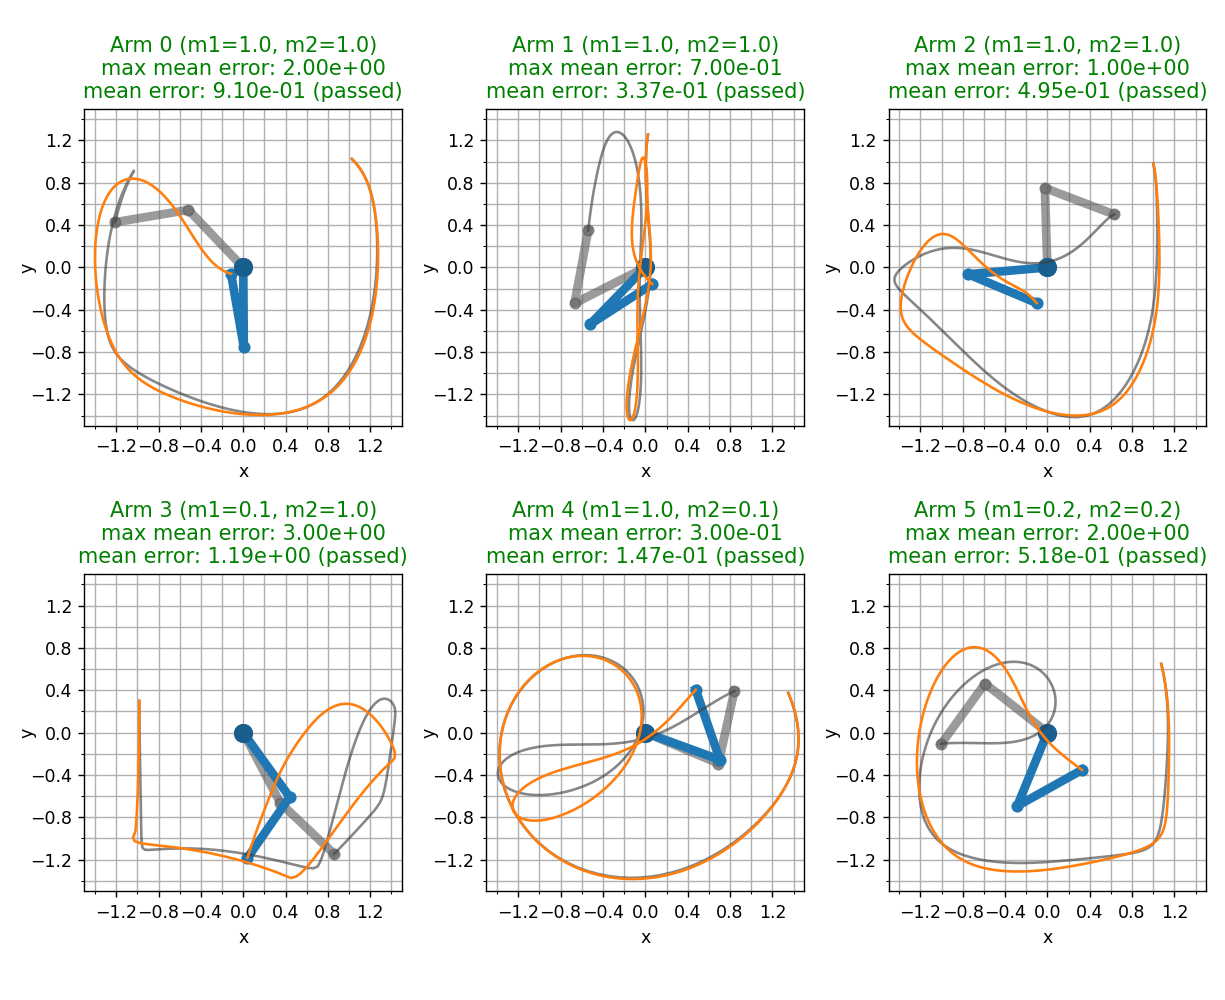

In [18]:
test_integrator(impl_euler)

## 5. Implementierung des Heun-Verfahrens

In [19]:
def heun(f: Callable[[np.ndarray], np.ndarray], x0: np.ndarray, dt: float, n: int):
    """
    Computes the simulation steps using the Heun method.
    :param f:   Function to integrate. Maps from an M-D numpy array to an M-D numpy array of time derivatives.
    :param x0:  M-D numpy array defining the starting point for the integration.
    :param dt:  Time step for the integration.
    :param n:   Number of steps to take.
    :return:    A n x M numpy array containing all intermediate states of the integration. The first element of this array must be x0.
    """
    # Implement this...
    z = np.zeros((n, x0.shape[0]))
    z[0] = x0
    for i in range (n-1):
        z_p = z[i] + dt * f(z[i])
        z[i+1] = z[i] + np.divide(dt, 2) * (f(z[i]) + f(z_p))
    return z



### Öffentliche Tests

<IPython.core.display.Javascript object>


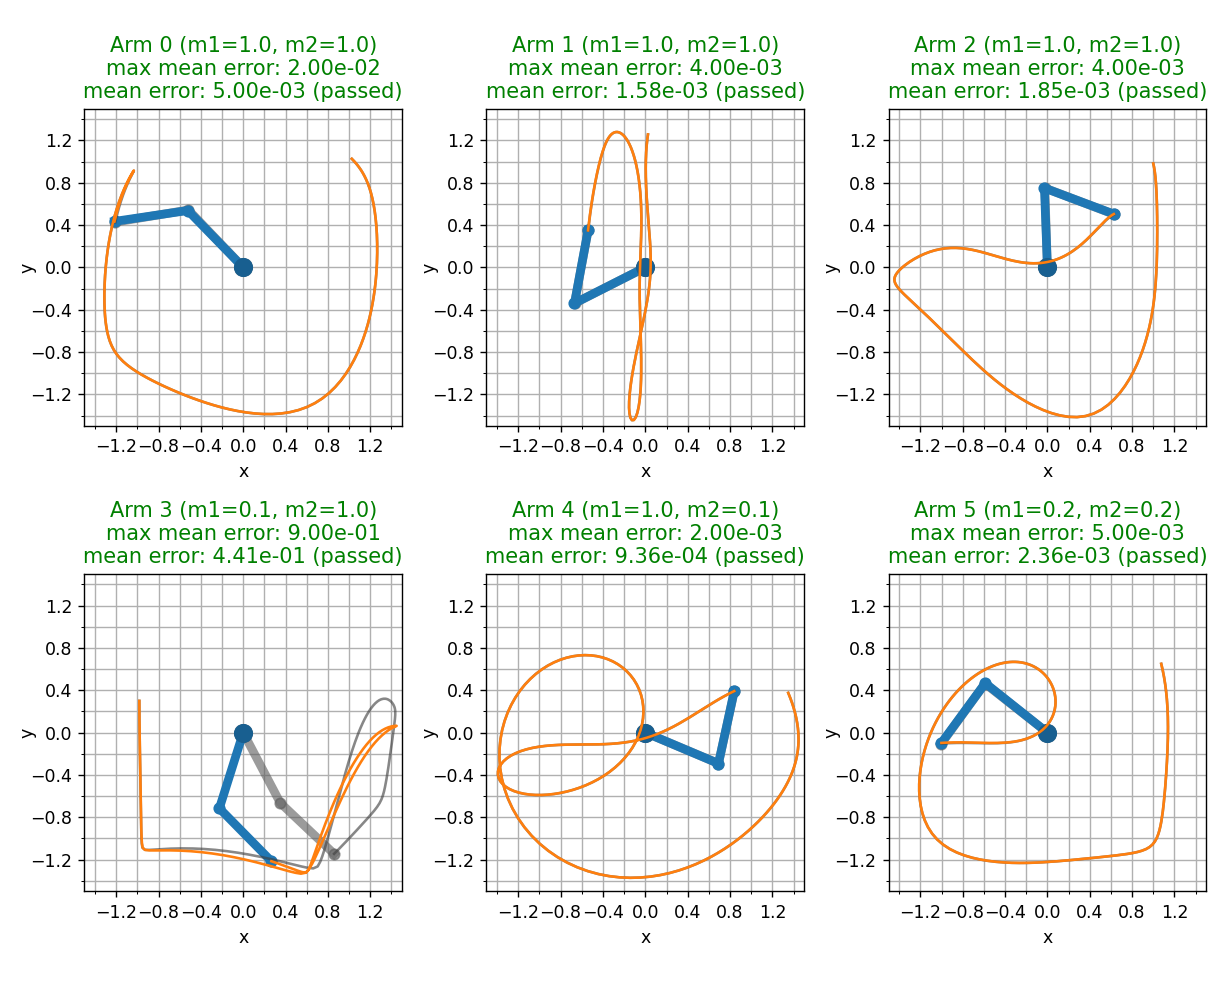

In [20]:
test_integrator(heun)

## 6. Implementierung des Runge-Kutta-Verfahrens vierter Ordnung

In [21]:
def rk4(f: Callable[[np.ndarray], np.ndarray], x0: np.ndarray, dt: float, n: int):
    """
    Computes the simulation steps using the RK4 method.
    :param f:   Function to integrate. Maps from an M-D numpy array to an M-D numpy array of time derivatives.
    :param x0:  M-D numpy array defining the starting point for the integration.
    :param dt:  Time step for the integration.
    :param n:   Number of steps to take.
    :return:    A n x M numpy array containing all intermediate states of the integration. The first element of this array must be x0.
    """
    # Implement this...
    z = np.zeros((n, x0.shape[0]))
    z[0] = x0
    for i in range (n-1):
        s1 = f(z[i])
        s2 = f(z[i] + np.divide(dt, 2) * s1)
        s3 = f(z[i] + np.divide(dt, 2) * s2)
        s4 = f(z[i] + dt * s3)
        z[i+1] = z[i] + dt * (1.0/6.0 * s1 + 1.0/3.0 * s2 + 1.0/3.0 * s3  + 1.0/6.0 * s4) 
    return z


### Öffentliche Tests

<IPython.core.display.Javascript object>


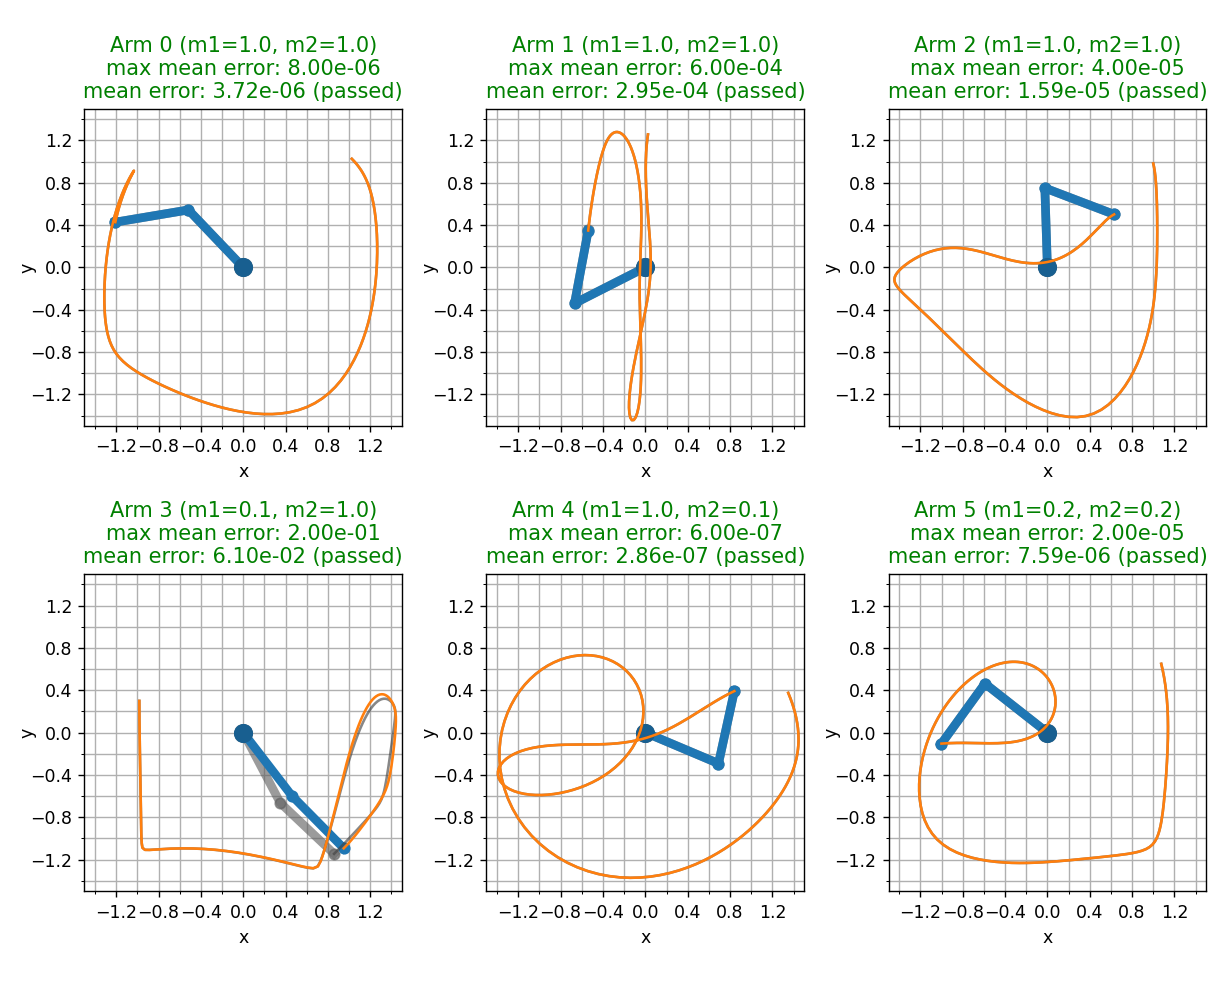

In [22]:
test_integrator(rk4)

## Spielwiese
Hier kannst du deine Verfahren nach Belieben Testen, Debuggen und miteinander vergleichen.

In [ ]:
# Change these parameters however you wish
l = np.array([0.75, 0.7])
m = np.array([1., 1.])
dt = 0.01
g = 9.81
n = 200
x0 = np.array([0.5, 0.5, 0.0, 0.0])

fig, axes = setup_axes(1)

# Set up robot
arm = RobotArm(fig, axes[0], l)
arm.render()

# Feel free to change the integrator according to your liking
integrator1 = expl_euler
# The second integrator will be rendered as a shadow
integrator2 = impl_euler

trajectory1 = integrator1(lambda x: forward_dynamics(x, l, m, g), x0, dt, n)
trajectory2 = integrator2(lambda x: forward_dynamics(x, l, m, g), x0, dt, n)

check_shape(trajectory1, (n, x0.shape[0]), "trajectory1")
check_shape(trajectory2, (n, x0.shape[0]), "trajectory2")

# Render the generated trajectory and the ground truth
arm.start_drawing()

last_render_time = 0.0
# Do not render every step to speed up the visualization 
# (feel free to cahnge this if you want to see more steps)
render_interval = 10
for j, (x1, x2) in enumerate(zip(trajectory1, trajectory2)):
    arm.set_joint_pos(x1[:2])
    arm.set_shadow_joint_pos(x2[:2])

    if j % render_interval == 0:
        now = time.time()
        time.sleep(max(0.0, last_render_time + render_interval * dt - now))
        arm.render()
        last_render_time = now
arm.render()